# Download and extract data

In [1]:
# Import required packages
import os, wget, tarfile
import numpy as np
import pandas as pd
import random
import sklearn
import re
import matplotlib.pyplot as plt

In [2]:
base_dir = "/home/himalaya/Desktop/coding/projects/small-image-search-engine/"
raw_data_dir = os.path.join(base_dir, 'data/raw')
if(os.path.exists(os.path.join(raw_data_dir, "cifar-10-python.tar.gz")) == False):
    url = "http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz"
    wget.download(url, raw_data_dir)

In [3]:
file_handler = tarfile.open(os.path.join(raw_data_dir, "cifar-10-python.tar.gz"))
file_handler.extractall(raw_data_dir)
file_handler.close()

# Load data

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dictionary = pickle.load(fo, encoding='bytes')
    return dictionary

In [5]:
cifar_raw_data_dir = os.path.join(raw_data_dir, "cifar-10-batches-py")
train_filenames = []
for filename in os.listdir(cifar_raw_data_dir):
    if re.search("^data_batch_[0-9]$", filename):
        train_filenames.append(filename)

In [6]:
temp_data = []
temp_labels = []
useful_keys = [b'data', b'keys']

for filename in train_filenames:
    temp_data_path = os.path.join(cifar_raw_data_dir, filename)
    temp_data.append(unpickle(temp_data_path)[b'data'])
    temp_labels.append(np.array(unpickle(temp_data_path)[b'labels']))
    
train_data = np.concatenate(temp_data, axis=0)
train_labels = np.concatenate(temp_labels, axis=0)

In [7]:
meta_data_dict = unpickle(os.path.join(cifar_raw_data_dir, 'batches.meta'))
test_data_dict = unpickle(os.path.join(cifar_raw_data_dir, 'test_batch'))

In [8]:
meta_data_dict.keys()

dict_keys([b'num_cases_per_batch', b'label_names', b'num_vis'])

In [9]:
test_data_dict.keys()

dict_keys([b'batch_label', b'labels', b'data', b'filenames'])

In [10]:
# Create validation set using stratified split
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(train_data, train_labels, test_size=0.2, 
                                                      stratify=train_labels, shuffle=True)
X_test, y_test = test_data_dict[b'data'], np.array(test_data_dict[b'labels'])

# Data exploration

In [11]:
print(f"Total number of training instances: {len(X_train)}")
print(f"Total number of validation instances: {len(X_valid)}")
print(f"Total number of test instances: {len(X_test)}")
print(f"Total number of unique classes: {len(np.unique(y_train))}")

Total number of training instances: 40000
Total number of validation instances: 10000
Total number of test instances: 10000
Total number of unique classes: 10


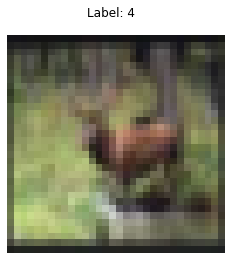

In [12]:
# Display a random image
random_idx = np.random.randint(0, len(X_train))
plt.imshow(X_train[random_idx].reshape(3,32,32).transpose(1,2,0))
plt.suptitle(f"Label: {y_train[random_idx]}")
plt.axis("off")
plt.show()

In [13]:
mapping_labels = dict(zip(np.unique(y_train), meta_data_dict[b'label_names']))
convert_labels = lambda label:mapping_labels[label].decode('ascii')
train_labels_str = np.array(list(map(convert_labels, y_train)))

In [14]:
idx_for_plotting = np.array([])
train_coarse_labels = y_train

for i, label in enumerate(set(y_train)):
    class_img_idx = np.where(y_train == label)[0]
    some_class_img_idx = np.random.choice(class_img_idx, size=8)
    idx_for_plotting = np.concatenate((idx_for_plotting, some_class_img_idx), axis=None)

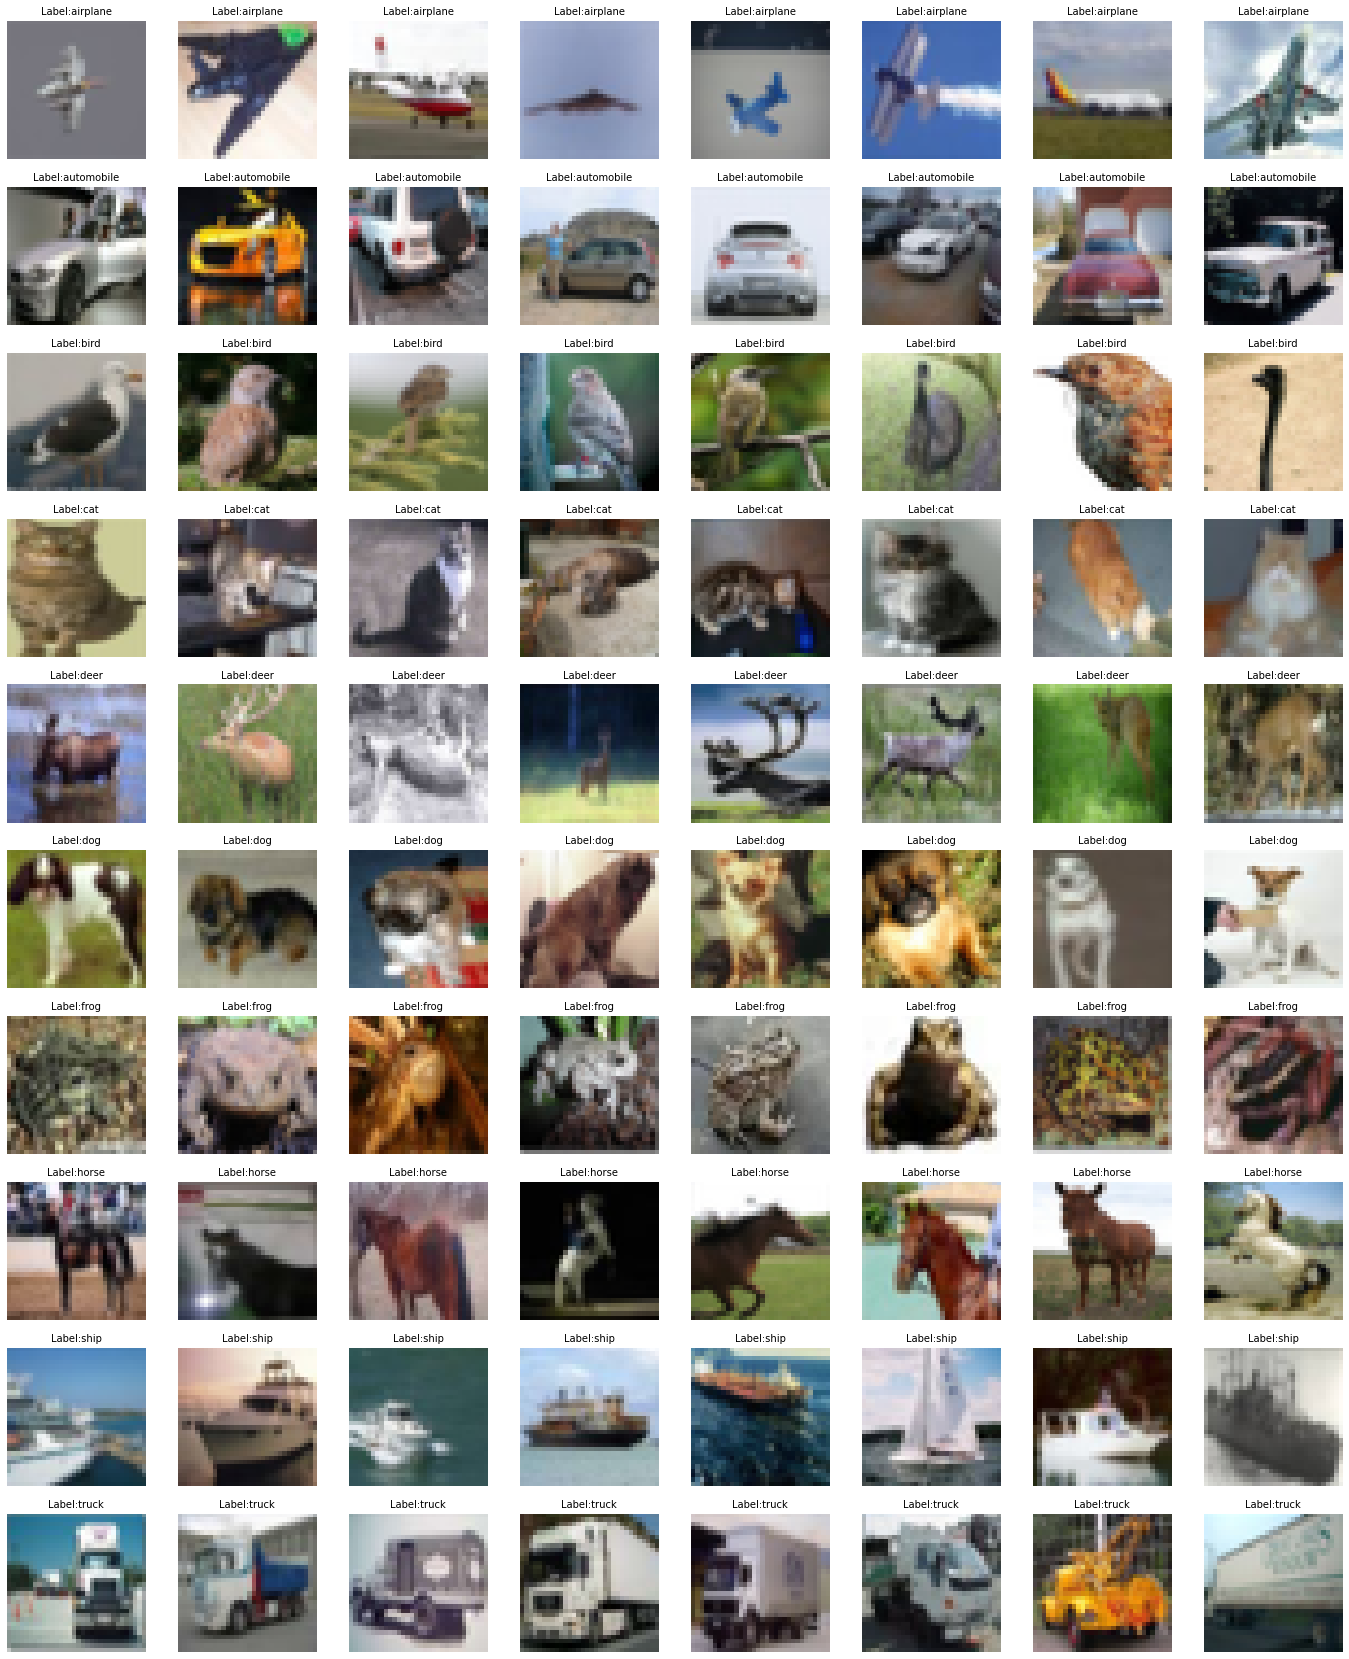

In [15]:
ncols = 8
nrows = 10

fig, ax = plt.subplots(nrows, ncols)
fig.set_size_inches(ncols*3, nrows*3)

idx_for_plotting = idx_for_plotting.astype(int)

idx = 0
for row in range(nrows):
    for col in range(ncols):
        ax[row, col].axis("off")
        label = train_labels_str[idx_for_plotting[idx]]
        ax[row, col].set_title(f"Label:{label}", fontsize=10)
        ax[row, col].imshow(X_train[idx_for_plotting[idx]].reshape(3,32,32).transpose(1,2,0))
        idx += 1

In [16]:
X_train = X_train.reshape(X_train.shape[0],3,32,32).transpose(0,2,3,1)
X_valid = X_valid.reshape(X_valid.shape[0],3,32,32).transpose(0,2,3,1)
X_test = X_test.reshape(X_test.shape[0],3,32,32).transpose(0,2,3,1)

# Load pre-trained model for transfer learning

In [17]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(
        include_top=False,
        weights='imagenet',
        input_tensor=None,
        input_shape=X_train[0].shape)

base_model.trainable = False

print(base_model.summary())

2022-06-09 02:37:02.681757: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2022-06-09 02:37:02.681794: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: LegionY540
2022-06-09 02:37:02.681803: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: LegionY540
2022-06-09 02:37:02.681892: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 470.129.6
2022-06-09 02:37:02.681919: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 470.129.6
2022-06-09 02:37:02.681926: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 470.129.6
2022-06-09 02:37:02.682201: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-crit

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 32, 32, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 32, 32, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 16, 16, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 16, 16, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 16, 16, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 8, 8, 128)         0     

In [18]:
from tensorflow.keras.applications.vgg16 import preprocess_input

X_train_preprocessed = preprocess_input(X_train)
X_test_preprocessed = preprocess_input(X_test)

# Define model architecture

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense

model = Sequential([
    base_model,
    Flatten(),
    Dense(units=512, activation='relu'),
    Dense(units=256, activation='relu'),
    Dense(units=128, activation='relu'),
    Dense(units=10, activation='softmax')
])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656    
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 10)                1290      
                                                                 
Total params: 15,142,858
Trainable params: 428,170
Non-t

In [20]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics='accuracy')

# Fit model

In [21]:
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid), batch_size=32)

Epoch 1/10
1250/1250 [==============================] - 115s 91ms/step - loss: 1.4792 - accuracy: 0.5228 - val_loss: 1.2378 - val_accuracy: 0.5729
Epoch 2/10
1250/1250 [==============================] - 115s 92ms/step - loss: 1.1188 - accuracy: 0.6136 - val_loss: 1.1772 - val_accuracy: 0.5970
Epoch 3/10
1250/1250 [==============================] - 115s 92ms/step - loss: 1.0121 - accuracy: 0.6483 - val_loss: 1.1493 - val_accuracy: 0.6121
Epoch 4/10
1250/1250 [==============================] - 115s 92ms/step - loss: 0.9160 - accuracy: 0.6816 - val_loss: 1.2184 - val_accuracy: 0.5940
Epoch 5/10
1250/1250 [==============================] - 115s 92ms/step - loss: 0.8132 - accuracy: 0.7150 - val_loss: 1.2374 - val_accuracy: 0.6145
Epoch 6/10
1250/1250 [==============================] - 115s 92ms/step - loss: 0.7161 - accuracy: 0.7487 - val_loss: 1.3161 - val_accuracy: 0.6023
Epoch 7/10
1250/1250 [==============================] - 115s 92ms/step - loss: 0.6249 - accuracy: 0.7800 - val_loss: 1

# Performance evaluation

In [22]:
def accuracy(target, prediction):
    return np.sum(target == prediction)/len(target)

In [23]:
y_pred = model.predict(X_test)
print(f"Accuracy on test set: {accuracy(y_test, np.argmax(y_pred, axis=1))}")

313/313 [==============================] - 23s 73ms/step
Accuracy on test set: 0.5958


# Get top 5 matches for input image

In [24]:
print("Layer names are as follows:")
for i, layer in enumerate(model.layers):
    print(f"Layer {i+1}: {layer.name}")

Layer names are as follows:
Layer 1: vgg16
Layer 2: flatten
Layer 3: dense
Layer 4: dense_1
Layer 5: dense_2
Layer 6: dense_3


In [71]:
from keras.models import Model

intermediate_layer_model = Model(inputs=model.input, 
                                outputs=model.get_layer('dense_2').output)

all_X = np.concatenate([X_train, X_valid, X_test], axis=0)
all_y = np.concatenate([y_train, y_valid, y_test], axis=0)
all_y_str = np.array(list(map(convert_labels, all_y)))

all_encodings = intermediate_layer_model.predict(all_X)

1875/1875 [==============================] - 136s 72ms/step


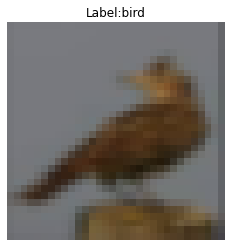

In [121]:
random_img_idx = np.random.randint(0, len(all_X))
plt.title(f"Label:{all_y_str[random_img_idx]}", fontsize=12)
plt.imshow(all_X[random_img_idx])
plt.axis('off')
plt.show()

In [122]:
reqd_no_of_matches = 5
random_img_arr = np.expand_dims(all_X[random_img_idx], axis=0)
encoding_random_img = intermediate_layer_model.predict(random_img_arr)

1/1 [==============================] - 0s 25ms/step


In [123]:
encoding_diff = np.sum(np.abs(all_encodings - encoding_random_img), axis=1)
encoding_diff_df = pd.DataFrame(encoding_diff, columns=['absolute_difference'])
match_idx = encoding_diff_df.sort_values(by=['absolute_difference']).index[1:reqd_no_of_matches+1]

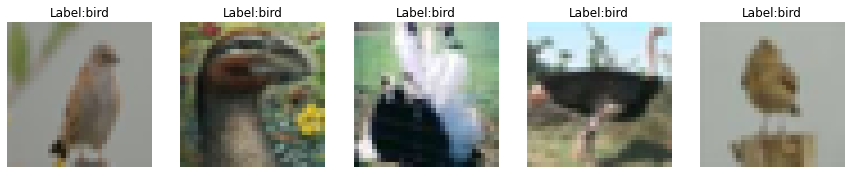

In [124]:
ncols = 5

fig, ax = plt.subplots(1, ncols, figsize=(15, 8))

idx = 0
for col in range(ncols):
    ax[col].axis("off")
    ax[col].set_title(f"Label:{all_y_str[match_idx[idx]]}", fontsize=12)
    ax[col].imshow(all_X[match_idx[idx]])
    idx += 1